## Imports

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
# import torch.utils.data
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchvision import datasets

from torchsummary import summary

import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

## Data load, preprocess 

In [3]:
data = datasets.CIFAR10(root='data', train=True, download=True)

means = data.data.mean(axis=(0, 1, 2)) / 255
stds = data.data.std(axis=(0, 1, 2)) / 255
print(means)
print(stds)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [4]:
transforms_train = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.RandomHorizontalFlip(0.5),
                            transforms.RandomCrop(32, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=means, std=stds)
                        ])

transforms_test = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=means, std=stds)
                        ])

In [5]:
train_data = datasets.CIFAR10(root='data', train=True, download=True, 
                              transform=transforms_train)

test_data = datasets.CIFAR10(root='data', train=False, download=True, 
                              transform=transforms_test)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
el_num = int(len(train_data) * 0.8)
train_data, val_data = torch.utils.data.random_split(train_data, [el_num, len(train_data) - el_num])

In [7]:
import copy
val_data = copy.deepcopy(val_data)
val_data.dataset.transform = transforms_test

In [8]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

40000
10000
10000


In [9]:
def inv_normalize_image(image, means, stds):
    image = transforms.Normalize(
            mean=-means/stds,
            std=1/stds
        )(image)
    return image

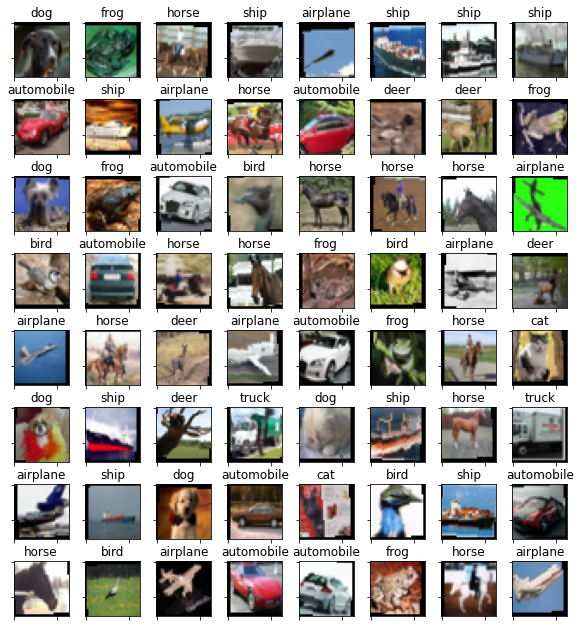

In [10]:
def plot_images(images, labels):
    n = int(np.sqrt(len(images)))

    fig, axis = plt.subplots(n, n, figsize=(10, 10))
    plt.subplots_adjust(top=0.95, hspace=0.4)

    for idx, im in enumerate(images):
        i = idx % n
        j = idx // n
        img = inv_normalize_image(im, means, stds)
        img = img.to('cpu').permute(1, 2, 0).numpy()
        img[img>1] = 1
        img[img<0] = 0

        axis[i][j].imshow(img)
        axis[i][j].set_title(labels[idx])
        axis[i][j].set_xticklabels([])
        axis[i][j].set_yticklabels([])
        axis[i][j].set_aspect('equal')

images, labels = zip(*[(im, lbl) for im, lbl in 
                       [train_data[i] for i in range(64)]])
classes = test_data.classes
labels = [classes[i] for i in labels]
plot_images(images, labels)

In [11]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=64)
val_loader = DataLoader(val_data, shuffle=True, batch_size=64)
test_loader = DataLoader(test_data, shuffle=True, batch_size=64)

## Train Functions

In [12]:
import time

def train(model, optimizer, train_data, val_data, test_data, num_epochs, device='cuda'):
    history = {}
    history['train_loss'] = []
    history['train_acc'] = []
    history['val_loss'] = []
    history['val_acc'] = []

    history['test_loss'] = 0
    history['test_acc'] = 0

    start_time = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        epoch_time = time.time()

        tr_loss, tr_acc = train_step(model, optimizer, train_data, epoch+1, num_epochs, device)
        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)

        vl_loss, vl_acc = validate(model, optimizer, val_data, epoch+1, num_epochs, device)
        history['val_loss'].append(vl_loss)
        history['val_acc'].append(vl_acc)

        epoch_time = time.time() - epoch_time
        print('Epoch completed in {:.0f}m {:.0f}s'.format(
            epoch_time // 60, epoch_time % 60))
        print('#' * 20)
        print()

    ts_loss, ts_acc = test(model, optimizer, test_data, epoch+1, num_epochs, device)
    history['test_loss'] = ts_loss
    history['test_acc'] = ts_acc

    start_time = time.time() - start_time
    print('Model trained in {:.0f}m {:.0f}s'.format(
    start_time // 60, start_time % 60))

    return history

In [13]:
def train_step(model, optimizer, train_data, epoch, epochs, device='cuda'):
    losses = []
    accs = []

    max_size = len(train_data.dataset)
    idx = 0
    idx_step = 0.0

    model.train()

    for data, target in train_data:
        idx += len(data)

        model.zero_grad()

        data = data.to(device)
        target = target.to(device)

        pred, _ = model(data)
        loss = loss_fn(pred, target)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        pred = torch.argmax(pred, dim=1)
        # target = torch.argmax(target, dim=1)
        accs.append(torch.sum(pred == target).item() / len(data))

        if (max_size * idx_step) <= idx:

            l = sum(losses) / len(losses)
            a = sum(accs) / len(accs)

            print_status('Train', epoch, epochs, l, a * 100, max_size * idx_step, max_size)

            idx_step += 0.2

    loss = sum(losses) / len(losses)
    acc = sum(accs) / len(accs)

    return loss, acc

In [14]:
def validate(model, optimizer, val_data, epoch, epochs, device='cuda'):
    losses = []
    accs = []

    model.eval()

    with torch.no_grad():
        for idx, (data, target) in enumerate(val_data):
            data = data.to(device)
            target = target.to(device)

            pred, _ = model(data)
            loss = loss_fn(pred, target)

            losses.append(loss.item())
            pred = torch.argmax(pred, dim=1)
            # target = torch.argmax(target, dim=1)
            accs.append(torch.sum(pred == target).item() / len(data))

    loss = sum(losses) / len(losses)
    acc = sum(accs) / len(accs)

    print_status('Validate', epoch, epochs, loss, acc * 100)

    return loss, acc

In [15]:
def test(model, optimizer, test_data, epoch, epochs, device='cuda'):
    losses = []
    accs = []

    model.eval()

    with torch.no_grad():
        for idx, (data, target) in enumerate(test_data):
            data = data.to(device)
            target = target.to(device)

            pred, _ = model(data)
            loss = loss_fn(pred, target)

            losses.append(loss.item())
            pred = torch.argmax(pred, dim=1)
            # target = torch.argmax(target, dim=1)
            accs.append(torch.sum(pred == target).item() / len(data))

    loss = sum(losses) / len(losses)
    acc = sum(accs) / len(accs)

    print_status('Test', epoch, epochs, loss, acc * 100)

    return loss, acc

In [16]:
def print_status(mode, epoch, epochs, loss, acc, idx = 0, max_idx = 0):
    s = mode
    if mode == "Validate":
        s += '\t({:2d}/{:2d})'.format(epoch, epochs)
    elif mode == "Train":
        s += '\t({:2d}/{:2d}) {:4.0f}/{:4d} ({:2.2f}%)'.format(
            epoch, epochs, idx, max_idx, idx/max_idx*100
        )

    s += ' loss: {:.3f}'.format(loss)
    s += ' accuracy: {:.3f}'.format(acc)

    print(s)

## Model

In [17]:
class VGG(nn.Module):
    def __init__(self, in_channels, classes):
        super(VGG, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg = VGG(3, 10).to(device)

In [19]:
summary(vgg, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]         590,080
      BatchNorm2d-13            [-1, 256, 8, 8]             512
             ReLU-14            [-1, 25

In [20]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=256)
val_loader = DataLoader(val_data, shuffle=True, batch_size=256)
test_loader = DataLoader(test_data, shuffle=True, batch_size=256)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss()
vgg = VGG(3,10).to(device)
optimizer = optim.Adam(vgg.parameters(), lr=0.0003)

In [23]:
history = train(vgg, optimizer, train_loader, val_loader, test_loader, 25, device=device)

Epoch 1/25
Train	( 1/25)    0/40000 (0.00%) loss: 2.323 accuracy: 10.547
Train	( 1/25) 8000/40000 (20.00%) loss: 4.130 accuracy: 10.400
Train	( 1/25) 16000/40000 (40.00%) loss: 3.234 accuracy: 10.615
Train	( 1/25) 24000/40000 (60.00%) loss: 2.924 accuracy: 11.174
Train	( 1/25) 32000/40000 (80.00%) loss: 2.753 accuracy: 11.791
Train	( 1/25) 40000/40000 (100.00%) loss: 2.619 accuracy: 12.958
Validate	( 1/25) loss: 2.208 accuracy: 13.809
Epoch completed in 1m 17s
####################

Epoch 2/25
Train	( 2/25)    0/40000 (0.00%) loss: 2.037 accuracy: 12.109
Train	( 2/25) 8000/40000 (20.00%) loss: 1.991 accuracy: 19.189
Train	( 2/25) 16000/40000 (40.00%) loss: 1.943 accuracy: 20.771
Train	( 2/25) 24000/40000 (60.00%) loss: 1.914 accuracy: 22.519
Train	( 2/25) 32000/40000 (80.00%) loss: 1.884 accuracy: 24.306
Train	( 2/25) 40000/40000 (100.00%) loss: 1.843 accuracy: 26.194
Validate	( 2/25) loss: 1.715 accuracy: 34.824
Epoch completed in 1m 16s
####################

Epoch 3/25
Train	( 3/25)  

## Visualization Functions

In [24]:
def visualize_loss(history):
    ind = list(range(len(history['train_loss'])))
    plt.plot(ind, history['train_loss'], label='line1')
    plt.plot(ind, history['val_loss'], label='line2')
    plt.scatter(ind[-1], history['test_loss'], label='point1')

    plt.legend([
        'train_loss',
        'val_loss',
        'test_loss'
    ])

    plt.ylabel('Loss')
    plt.title('Losses plot')
    plt.show()

In [25]:
def visualize_acc(history):
    ind = list(range(len(history['train_acc'])))
    plt.plot(ind, history['train_acc'], label='line1')
    plt.plot(ind, history['val_acc'], label='line2')
    plt.scatter(ind[-1], history['test_acc'], label='point1')

    plt.legend([
        'train_acc',
        'val_acc',
        'test_acc'
    ])

    plt.ylabel('Accuracy')
    plt.title('Accuracy plot')
    plt.show()

In [26]:
def get_predictions(model, data_loader, device):
    model.eval()
    images = []
    labels = []

    with torch.no_grad():
        for (data, target) in data_loader:
            data = data.to(device)
            pred, _ = model(data)
            pred = torch.argmax(pred, dim=1)
            classes = test_data.classes
            pred = [classes[i] for i in pred]

            images.append(data.cpu())
            labels += pred
            break

    images = torch.cat(images, dim=0)
    return images, labels

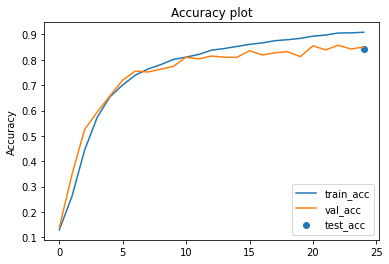

In [27]:
visualize_acc(history)

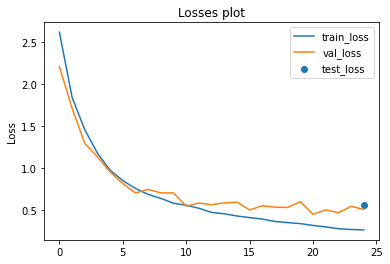

In [28]:
visualize_loss(history)

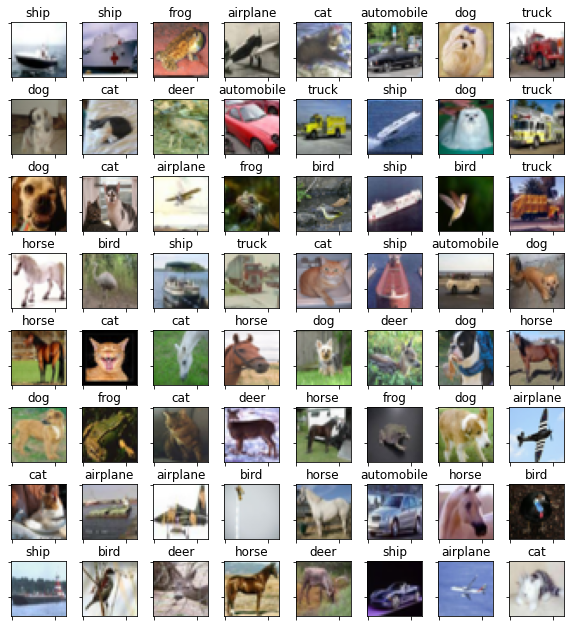

In [30]:
images, labels = get_predictions(vgg, test_loader, device)
plot_images(images[:64], labels[:64])